In [1]:
import os
import re
import json 
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
# sns.set_context("notebook", font_scale=0.8) 

%config InlineBackend.figure_format = 'retina'  
%config InlineBackend.print_figure_kwargs = {'dpi': 170}  

In [2]:
output_dir = Path('Output')
output_dir.mkdir(exist_ok=True)

In [3]:
clemb_dir = Path('/Users/nidhirbhavsar/Desktop/WORK/Clembench/clembench/')
clemrun_dir = Path('/Users/nidhirbhavsar/Desktop/WORK/Clembench/clembench-runs/')

In [4]:
with open(clemb_dir / 'backends/model_registry.json') as f:
    reg_data = json.load(f) 

reg = pd.DataFrame(reg_data) 
reg['model_name'] = reg.model_name.str.lower()
reg['model_id'] = reg.model_id.str.lower()
reg['release_date'] = pd.to_datetime(reg['release_date'])
reg = reg.set_index('model_name')

In [5]:
versions = {
    'gemini-1.0-pro-002': 'gemini-1.0-pro',
    'gemini-1.5-flash-002': 'gemini-1.5-flash-latest',
    'gemini-1.5-pro-002': 'gemini-1.5-pro-latest'
}
reg.index = reg.index.map(lambda x: versions.get(x, x))

In [6]:
reg['p_size_estimated'] = False 

In [7]:
exclusions = [
    'luminous-supreme-control', 
    'luminous-supreme', 
    'luminous-extended', 
    'luminous-base', 
    'llama-3.2-1b-instruct', 
    'llama-3.2-3b-instruct'
]

In [8]:
models_to_update = reg[
    (reg.open_weight == False) & 
    (~reg.index.isin(exclusions))
].index

In [9]:
models_to_update

Index(['gpt-4-1106-vision-preview', 'gpt-4o-2024-05-13', 'gpt-4o-2024-08-06',
       'gpt-4o-mini-2024-07-18', 'gpt-4-turbo-2024-04-09',
       'gpt-4-1106-preview', 'gpt-4-0125-preview', 'o1-preview-2024-09-12',
       'o1-mini-2024-09-12', 'gpt-3.5-turbo-0125', 'gpt-4-0613', 'gpt-4-0314',
       'gpt-3.5-turbo-1106', 'gpt-3.5-turbo-0613', 'command', 'command-light',
       'claude-v1.3', 'claude-v1.3-100k', 'claude-instant-1.2', 'claude-2',
       'claude-2.1', 'claude-3-opus-20240229', 'claude-3-sonnet-20240229',
       'claude-3-haiku-20240307', 'claude-3-5-sonnet-20240620',
       'gemini-1.0-pro-001', 'gemini-1.0-pro', 'gemini-1.0-pro-vision-001',
       'gemini-1.5-flash-001', 'gemini-1.5-pro-001', 'gemini-1.5-pro-latest',
       'gemini-1.5-flash-latest', 'gemini-1.5-flash-8b-001'],
      dtype='object', name='model_name')

In [10]:
reg.loc[models_to_update, 'parameters'] = '900B'
reg.loc[models_to_update, 'p_size_estimated'] = True

unknown parameter size for -- `mistral-medium-2312`

In [11]:
reg = reg[reg.parameters != ''] 

In [12]:
reg['parameters'] = reg['parameters'].str.replace('B', '').astype(float)

In [13]:
clemb = pd.read_csv(clemrun_dir / 'v1.6' / 'results.csv')
clemb = clemb.rename(columns={clemb.columns[0]: 'models'})

In [14]:
clemb.models = clemb.models.apply(lambda x: re.sub(r'(\w*)-t0.0.*', r'\1', x).lower())
clemb = clemb.set_index('models')

In [15]:
both = set(clemb.index).intersection(set(reg.index))
missing = set(clemb.index) - set(reg.index)

print("Overlapping:", len(both), "Missing:", len(missing))

Overlapping: 62 Missing: 10


In [16]:
missing

{'dolphin-2.5-mixtral-8x7b',
 'mistral-medium-2312',
 'nous-hermes-2-mixtral-8x7b-sft',
 'qwen1.5-0.5b-chat',
 'qwen1.5-1.8b-chat',
 'qwen1.5-14b-chat',
 'qwen1.5-32b-chat',
 'yi-1.5-34b-chat',
 'yi-1.5-6b-chat',
 'yi-1.5-9b-chat'}

In [17]:
merged = pd.merge(reg, clemb, left_index=True, right_index=True, how='inner')

In [18]:
merged.parameters.tolist()

[8.0,
 70.0,
 405.0,
 141.0,
 46.7,
 900.0,
 900.0,
 900.0,
 900.0,
 900.0,
 900.0,
 900.0,
 900.0,
 900.0,
 123.0,
 35.0,
 104.0,
 900.0,
 900.0,
 900.0,
 900.0,
 900.0,
 900.0,
 900.0,
 900.0,
 7.0,
 7.0,
 7.0,
 70.0,
 70.0,
 13.0,
 70.0,
 13.0,
 13.0,
 33.0,
 34.0,
 7.0,
 34.0,
 70.0,
 46.7,
 34.0,
 7.0,
 7.0,
 7.0,
 72.0,
 3.8,
 7.0,
 7.0,
 72.0,
 32.0,
 8.0,
 35.0,
 9.0,
 27.0,
 70.0,
 7.0,
 2.0,
 7.0,
 7.0,
 2.0,
 8.0,
 70.0,
 123.0]

useful buckets: 

- \< 6
- (6, 10]
- (10, 60]
- (60, 100]
- (100, 200]
- \> 900

In [19]:
bin_edges = [0, 6, 10, 60, 100, 200, 1000]
bin_categories = ['tiny', 'v-small', 'small', 'medium', 'large', 'xxlarge']

merged.loc[:, 'size_bin'] = pd.cut(
    merged.dropna(subset=['parameters'])['parameters'], 
    bin_edges, 
    labels=bin_categories
)

In [20]:
merged.size_bin

model_name
meta-llama-3-8b-instruct-hf           v-small
meta-llama-3-70b-instruct-hf           medium
meta-llama-3.1-405b-instruct-turbo    xxlarge
mixtral-8x22b-instruct-v0.1             large
mixtral-8x7b-instruct-v0.1              small
                                       ...   
codegemma-7b-it                       v-small
gemma-2-2b-it                            tiny
meta-llama-3.1-8b-instruct            v-small
meta-llama-3.1-70b-instruct            medium
mistral-large-instruct-2407             large
Name: size_bin, Length: 63, dtype: category
Categories (6, object): ['tiny' < 'v-small' < 'small' < 'medium' < 'large' < 'xxlarge']

In [21]:
def plot_tick_with_offset(x, y, label, width=1, spacing=0.3, fontsize=12):  # increased spacing
    """Plot tick with aligned positions"""
    plt.plot([x, x+width], [y, y], color='gray', alpha=0.5)
    plt.text(x + width + spacing, y, label, 
            fontsize=fontsize,
            verticalalignment='center',
            horizontalalignment='left',
            bbox=dict(facecolor='white', 
                     alpha=0.9,    
                     edgecolor='none',
                     pad=1))

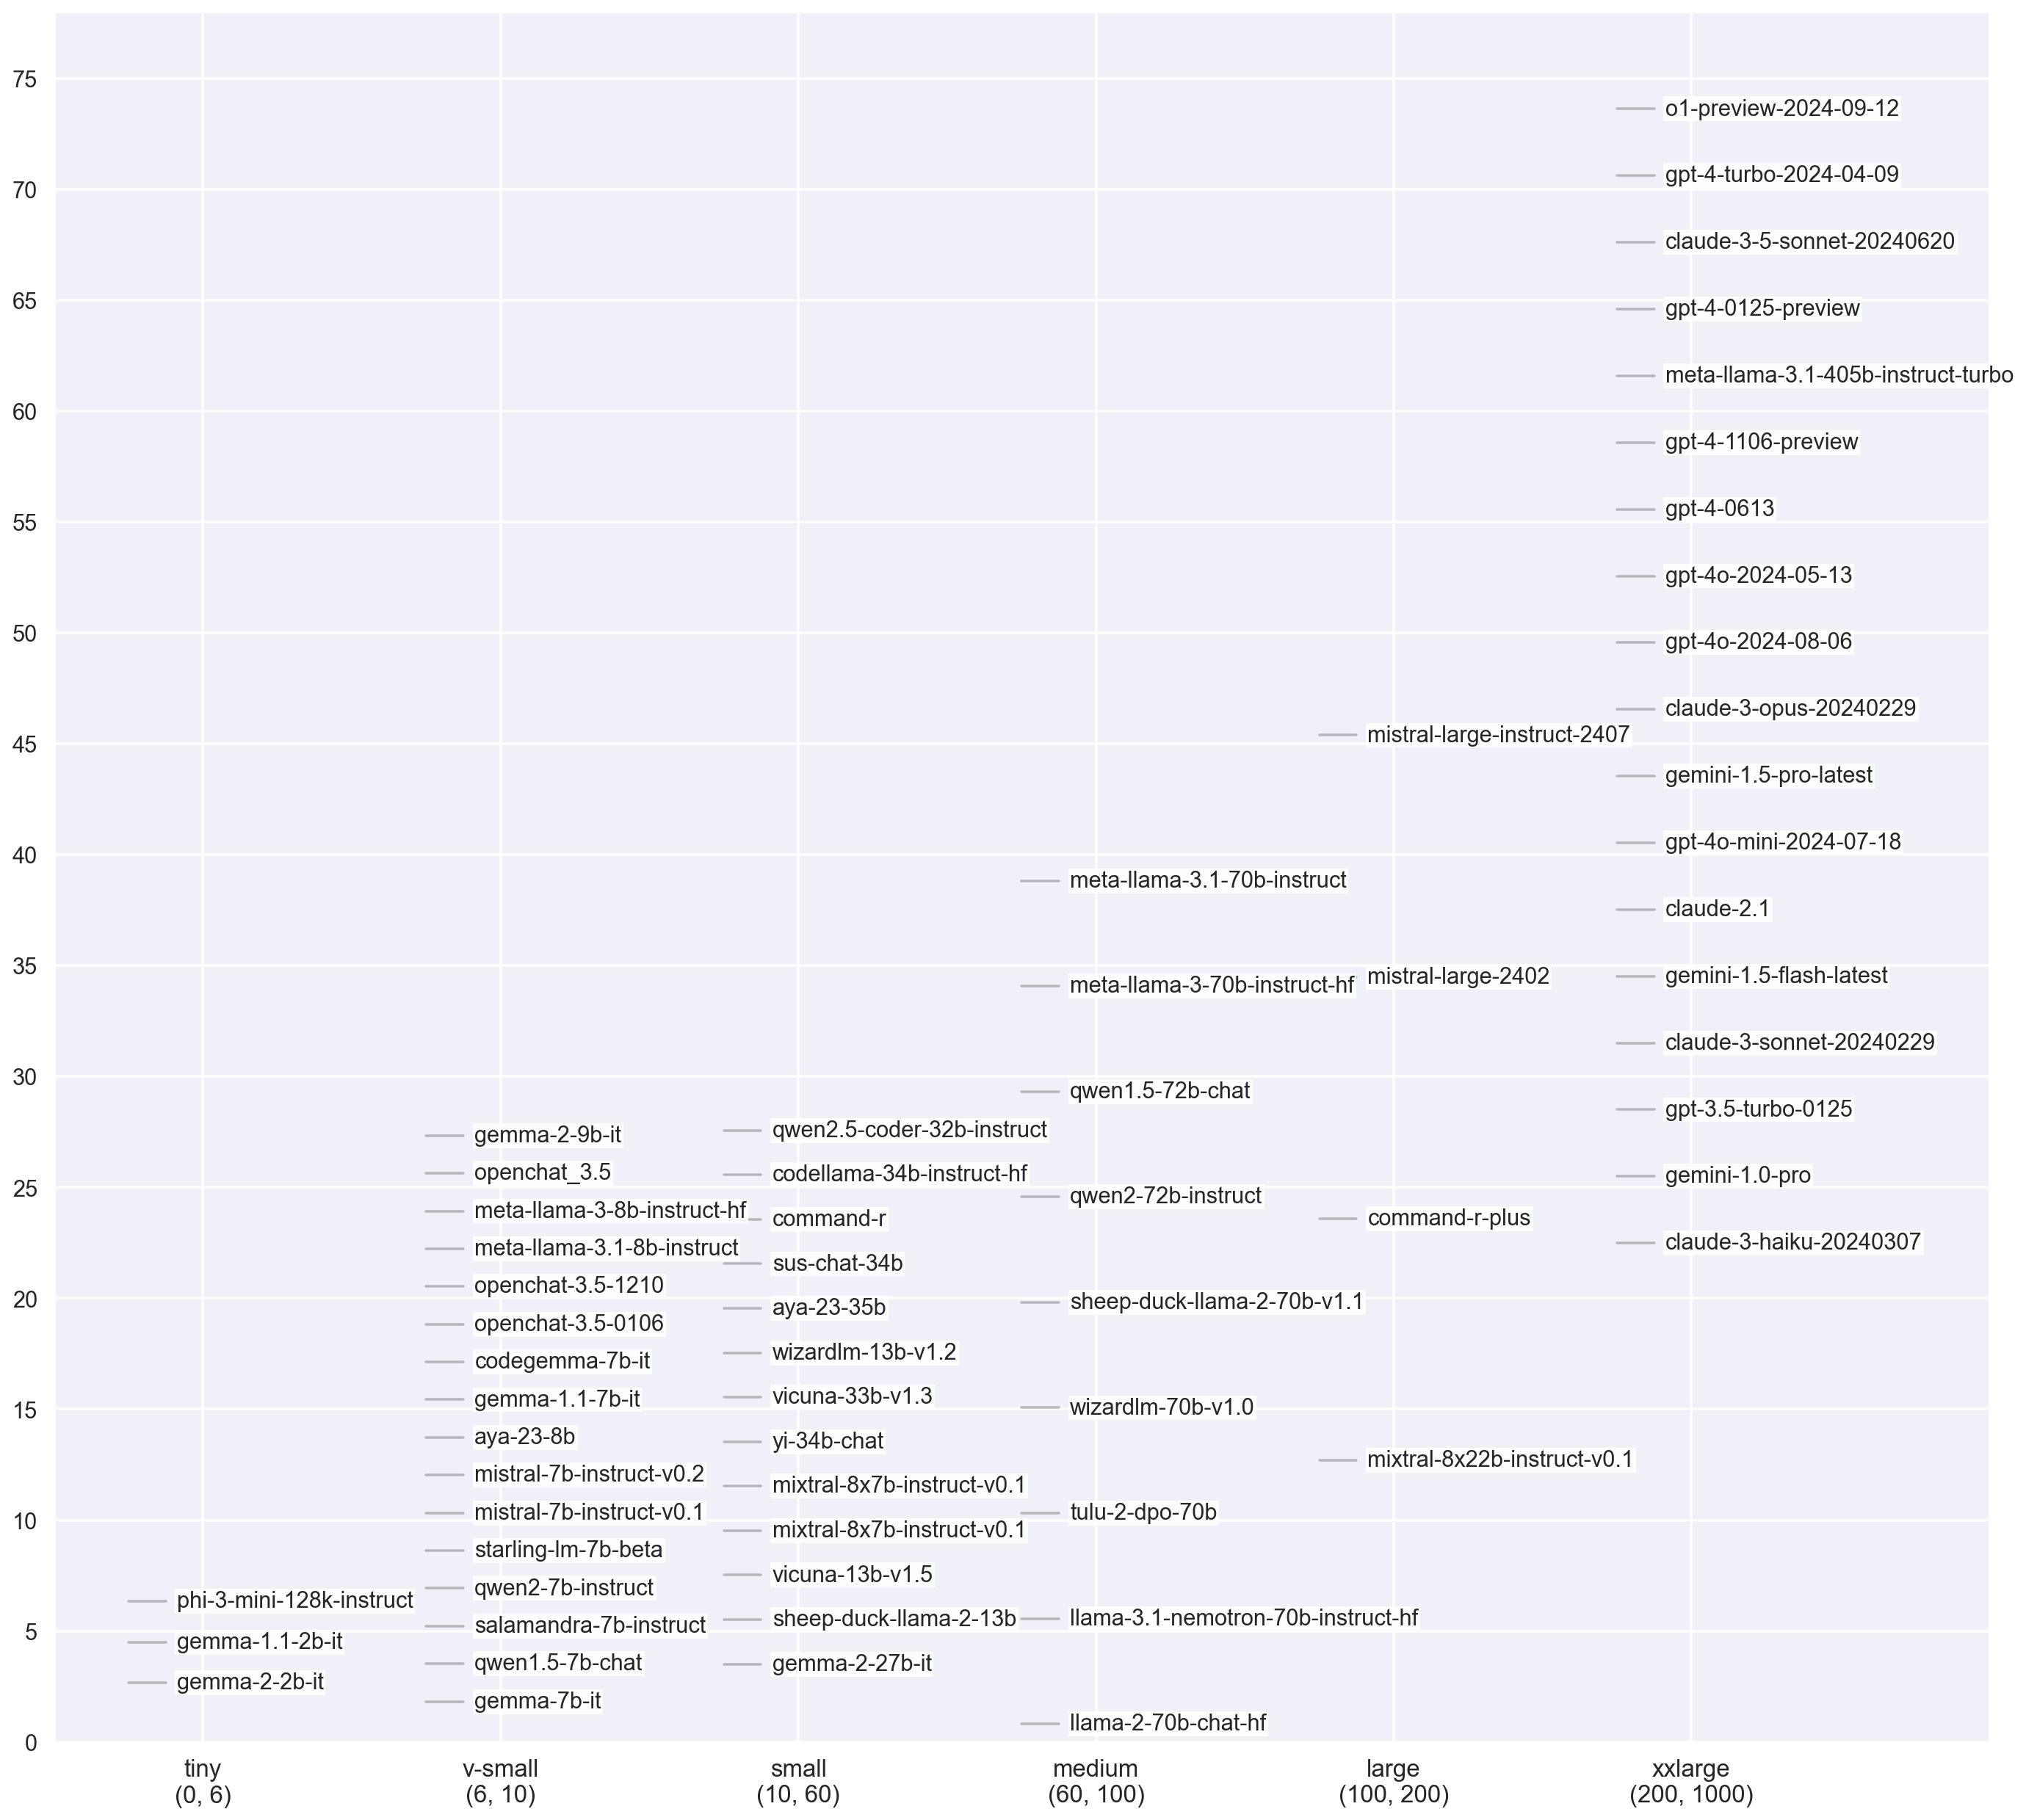

In [22]:
fig, ax = plt.subplots()
col_width = 8  

for col_idx, bin_category in enumerate(bin_categories):
    bin_data = merged[merged.size_bin == bin_category].sort_values('-, clemscore')
    
    if len(bin_data) > 0:
        y_positions = np.linspace(
            bin_data['-, clemscore'].min(),
            bin_data['-, clemscore'].max(),
            len(bin_data)
        )
        
        for (index, row), y_pos in zip(bin_data.iterrows(), y_positions):
            plot_tick_with_offset(
                col_idx * col_width, 
                y_pos, 
                row.name, 
                fontsize=13
            )

ax.set_ylim(0, 78)  # Adjusted y-axis limit
ax.set_xlim(-2, 50)  # Reduced x-axis limit

# Set more frequent y-ticks
ax.set_yticks(np.arange(0, 79, 5))  # Y-axis ticks every 5 units

ax.set_xticks(
    range(int(0 + col_width/3), len(bin_categories)*col_width, col_width),
    [f"{cat}\n({edges[0]}, {edges[1]})" for cat, edges in zip(bin_categories, zip(bin_edges[:-1], bin_edges[1:]))],
    rotation=0
)

fig.set_size_inches(20, 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
ax.grid(True, color='white', linestyle='-', linewidth=1.5)
ax.set_facecolor('#f0f0f8')
plt.savefig(output_dir / 'size_buckets_all.png', bbox_inches='tight')

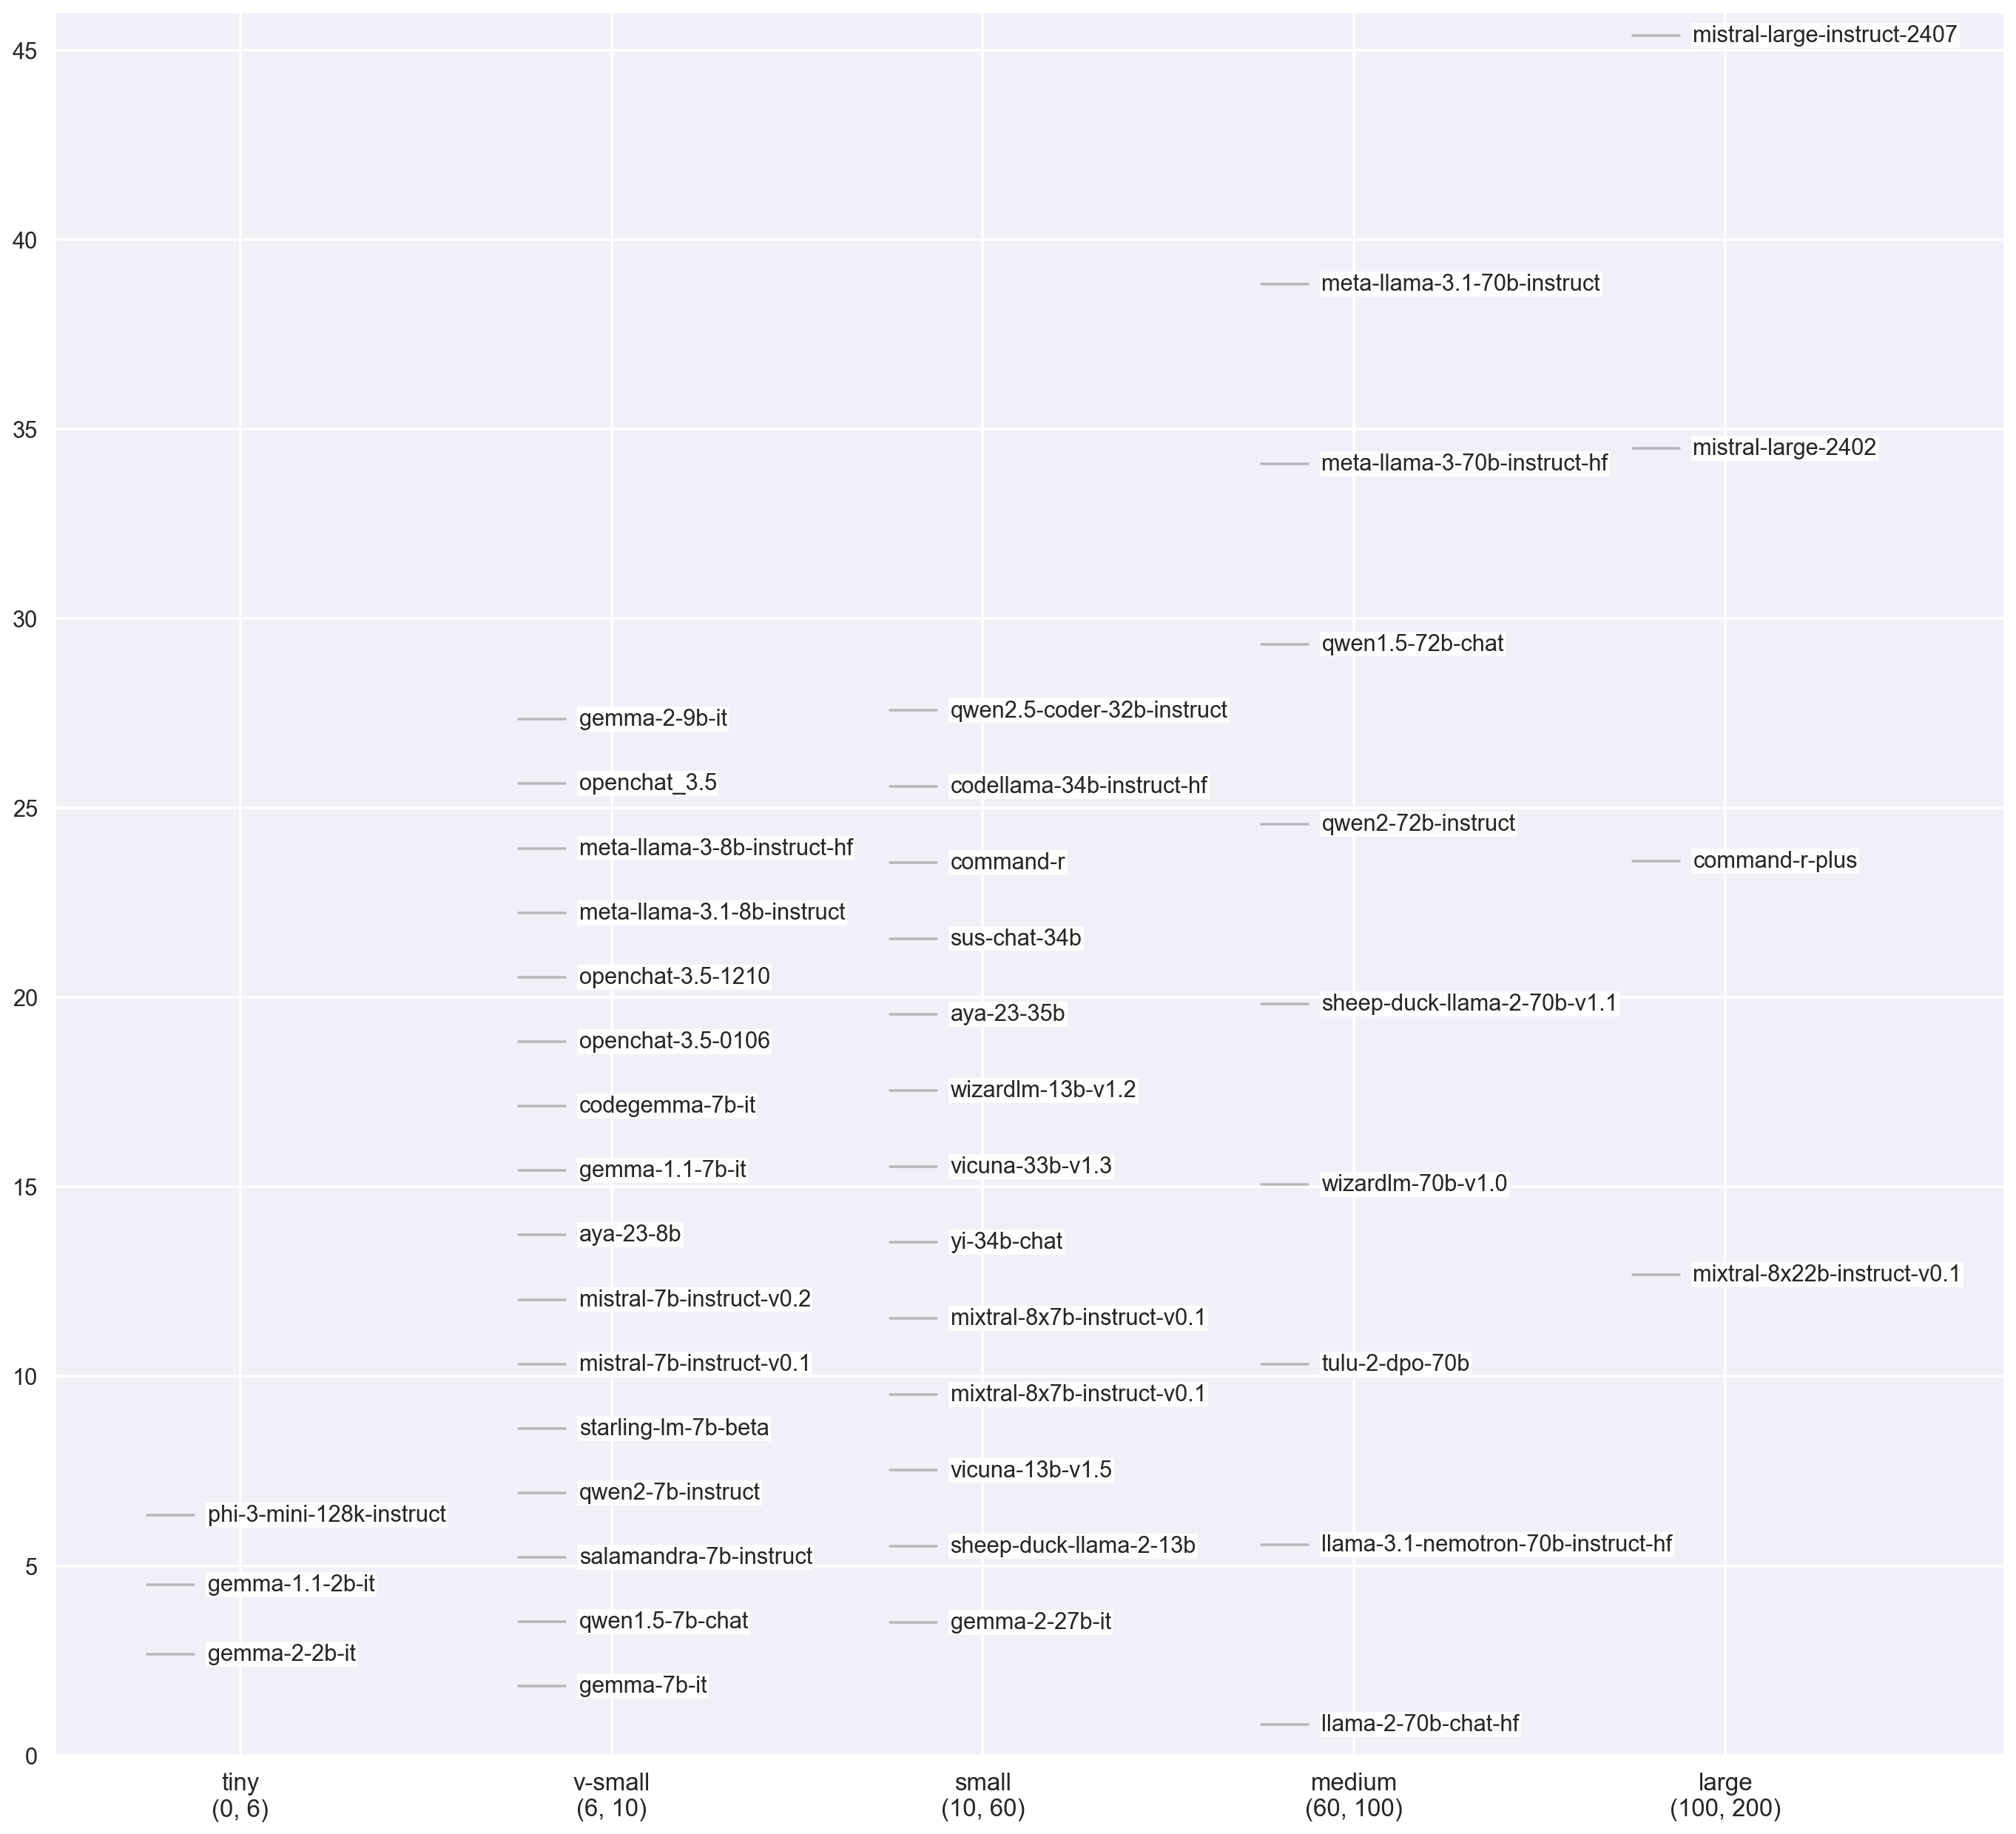

In [23]:
fig, ax = plt.subplots()
col_width = 8  

limited_categories = bin_categories[:-1]  # Exclude the last category

for col_idx, bin_category in enumerate(limited_categories):
    bin_data = merged[merged.size_bin == bin_category].sort_values('-, clemscore')
    
    if len(bin_data) > 0:
        y_positions = np.linspace(
            bin_data['-, clemscore'].min(),
            bin_data['-, clemscore'].max(),
            len(bin_data)
        )
        
        for (index, row), y_pos in zip(bin_data.iterrows(), y_positions):
            plot_tick_with_offset(
                col_idx * col_width, 
                y_pos, 
                row.name, 
                fontsize=13
            )

ax.set_ylim(0, 46)  
ax.set_xlim(-2, 40) 

# Set more frequent y-ticks
ax.set_yticks(np.arange(0, 47, 5))  

# Changed bin_categories to limited_categories here
ax.set_xticks(
    range(int(0 + col_width/3), len(limited_categories)*col_width, col_width),
    [f"{cat}\n({edges[0]}, {edges[1]})" for cat, edges in zip(limited_categories, zip(bin_edges[:-1], bin_edges[1:]))],
    rotation=0
)

fig.set_size_inches(20, 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
ax.grid(True, color='white', linestyle='-', linewidth=1.5)
ax.set_facecolor('#f0f0f8')
plt.savefig(output_dir / 'size_buckets_w_model_names.png', bbox_inches='tight')

#### Legacy Implementation

In [24]:
bin_edges = [0, 6, 10, 60, 100, 200, 1000]
bin_categories = ['tiny', 'v-small', 'small', 'medium', 'large', 'xxlarge']

merged.loc[:, 'size_bin'] = pd.cut(
    merged.dropna(subset=['parameters'])['parameters'], 
    bin_edges, 
    labels=bin_categories
)

def plot_tick(x, y, label, width=1, spacing=0.1, fontsize=12, offset=0.1):
    plt.plot([x, x+width], [y, y])
    plt.text(x + width + spacing, y-offset, label, fontsize=fontsize)

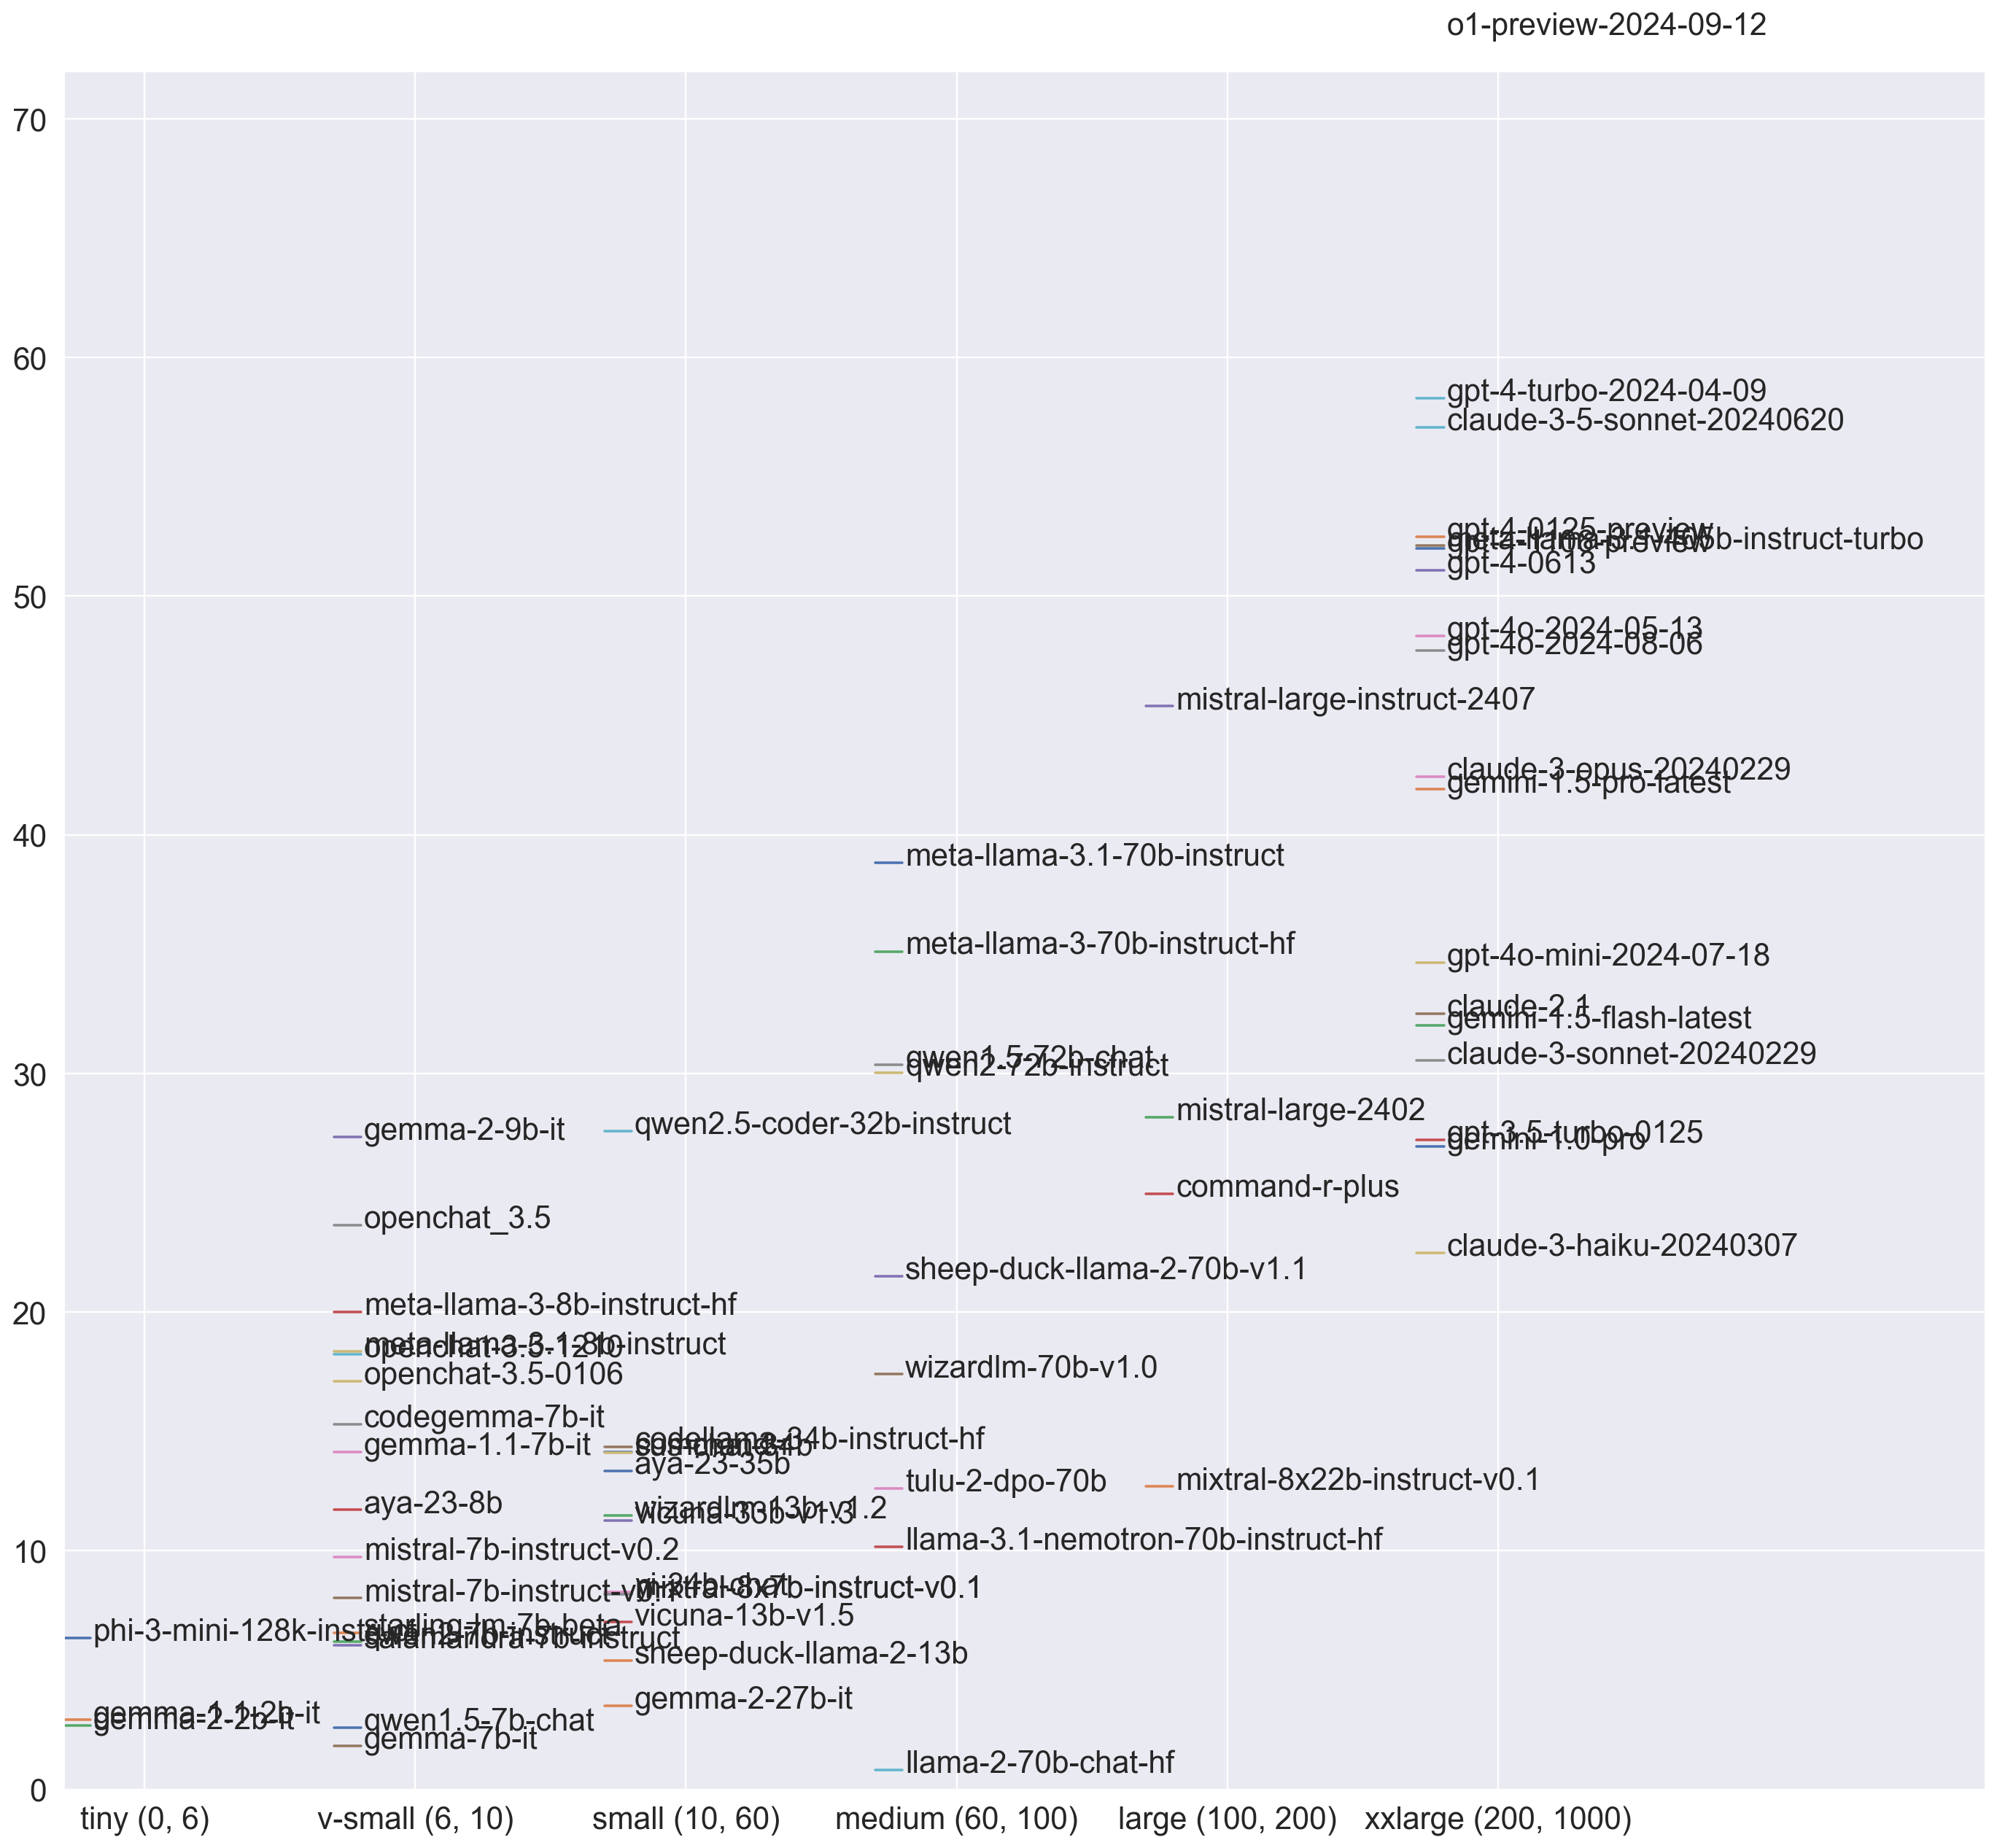

In [25]:
fig, ax = plt.subplots()
col_width = 10

for col_idx, bin_category in enumerate(bin_categories):
    for index, row in merged[merged.size_bin == bin_category].iterrows():
        plot_tick(col_idx * col_width, row['-, clemscore'], row.name, fontsize=18)

ax.set_ylim((0, 72))
ax.set_xlim((0, 71))

ax.set_xticks(
    range(int(0 + col_width/3), len(bin_categories)*col_width, col_width),
    [f"{cat} {edges}" for cat, edges in zip(bin_categories, zip(bin_edges[:-1], bin_edges[1:]))]
)

fig.set_size_inches(20, 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig(output_dir / 'size_buckets_all_original.png', bbox_inches='tight')

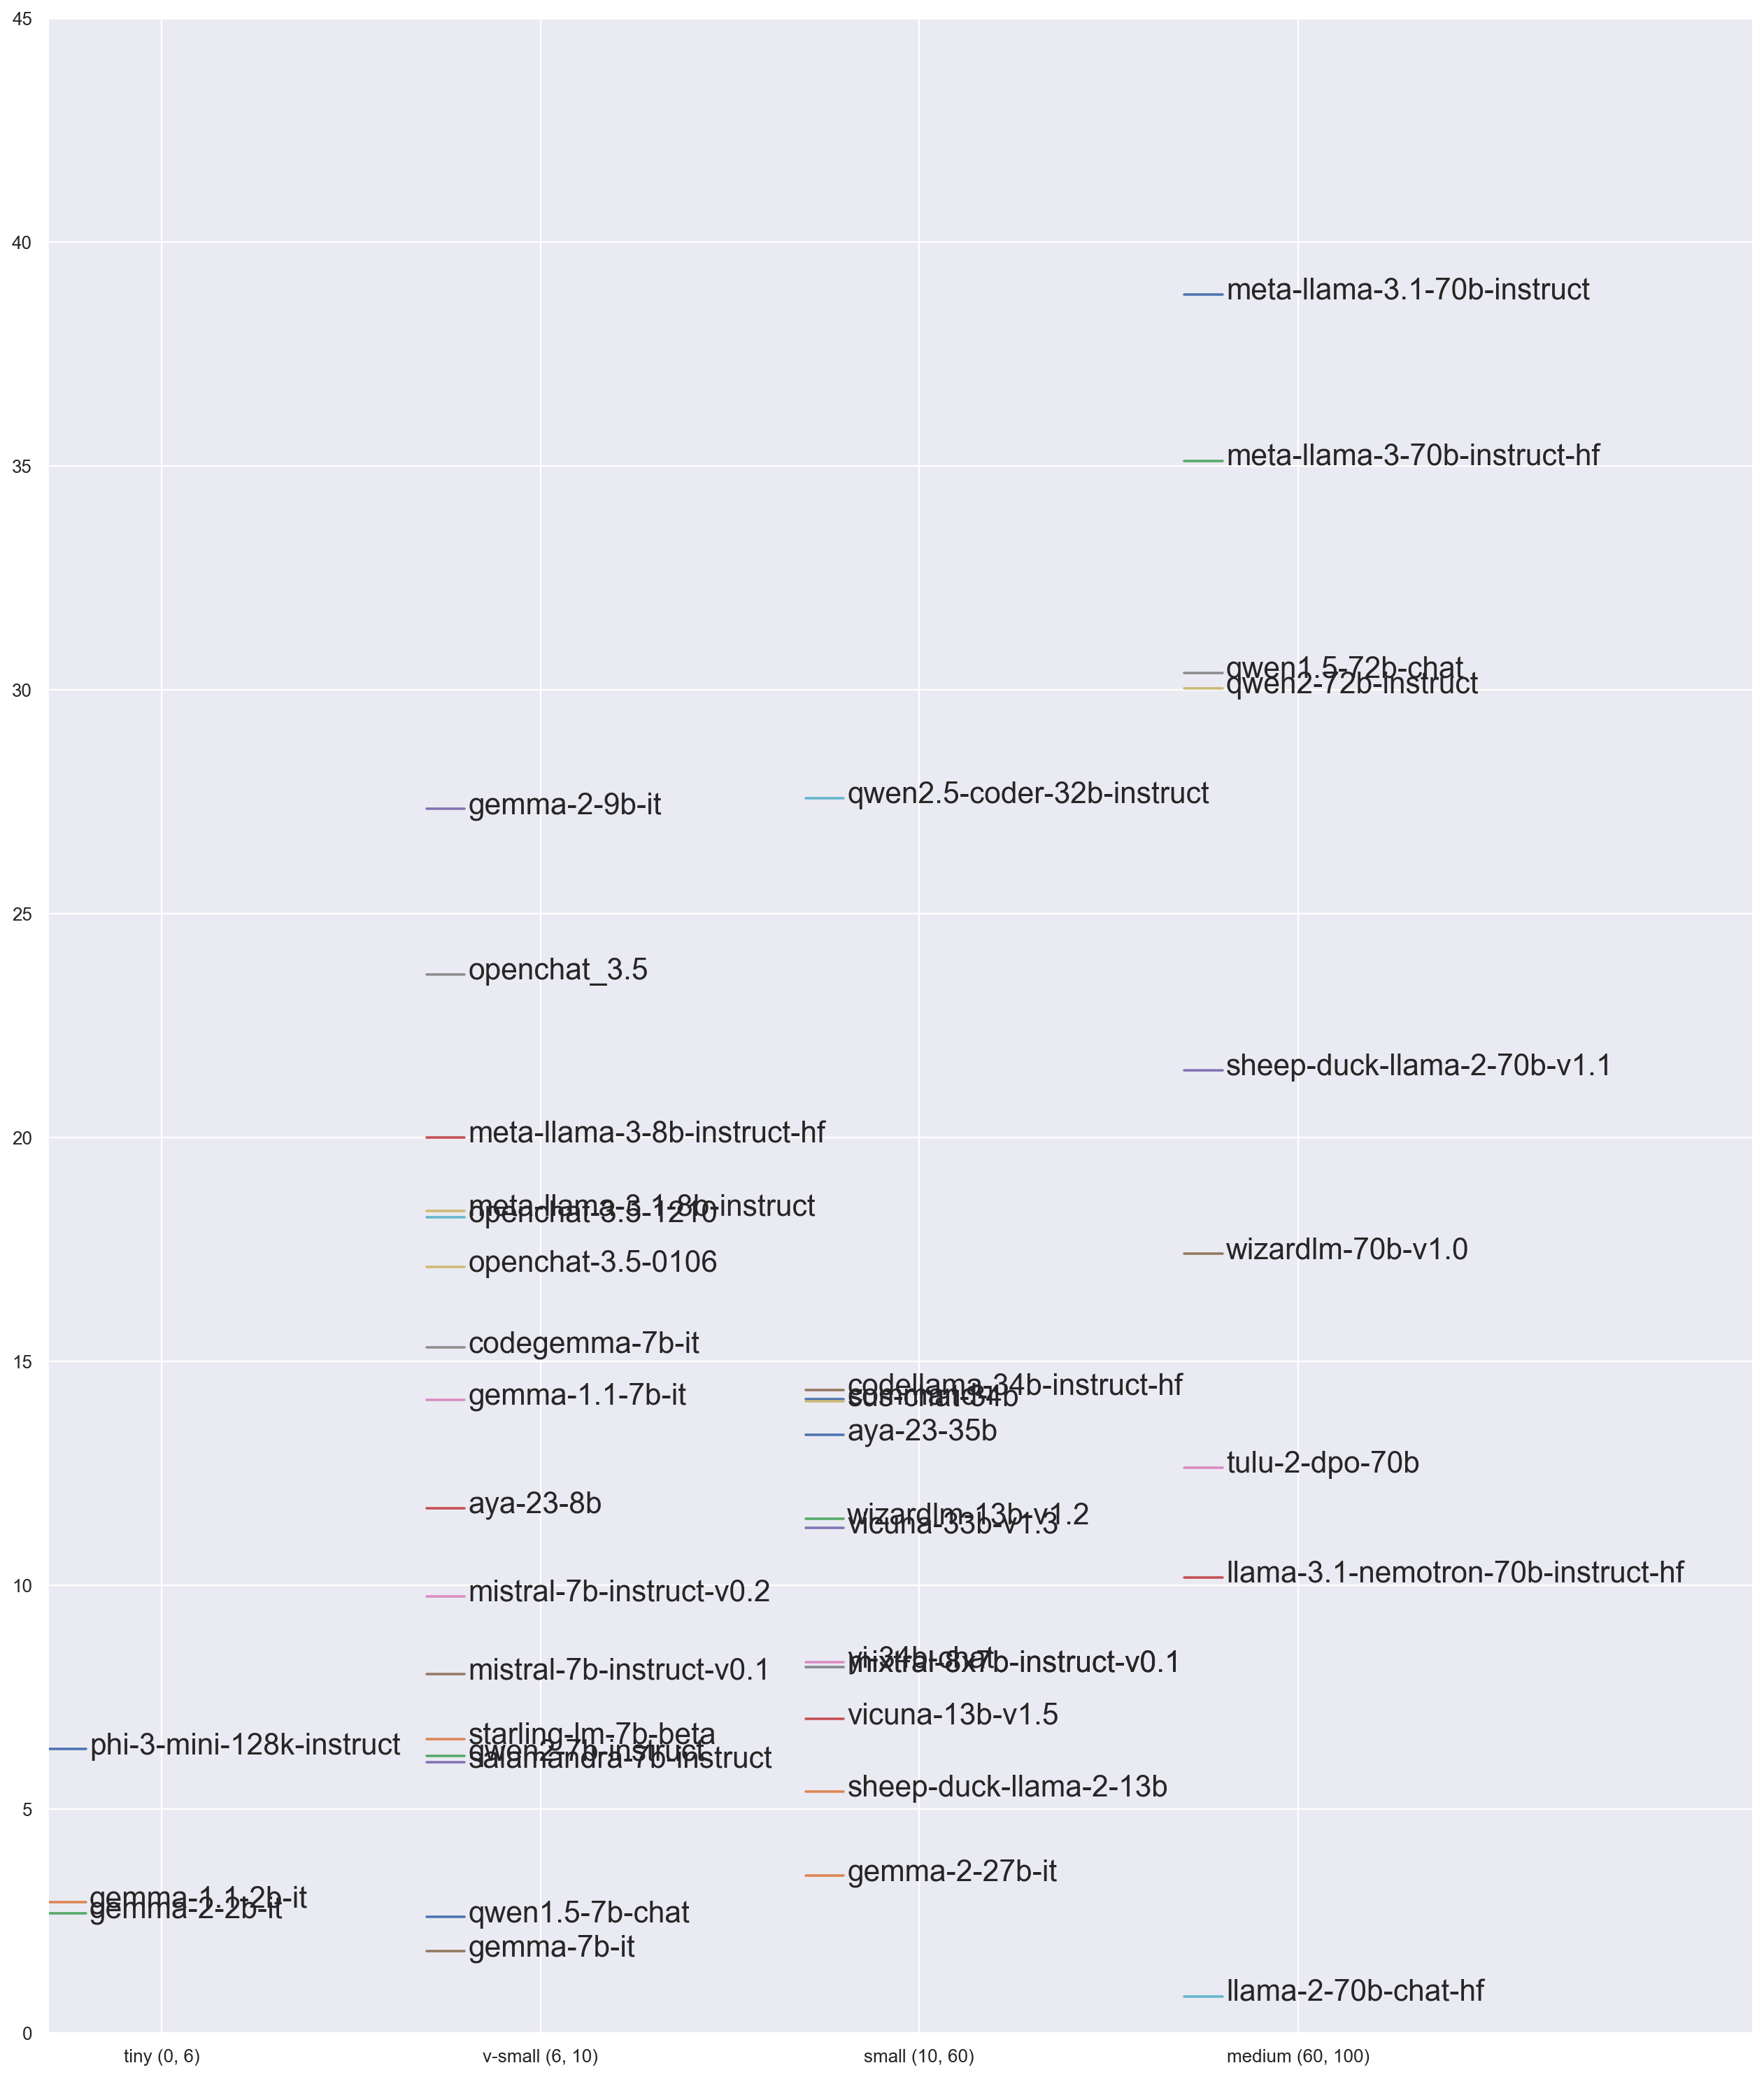

In [26]:
fig, ax = plt.subplots()
limited_categories = bin_categories[:-2]  # Exclude the last two categories

for col_idx, bin_category in enumerate(limited_categories):
    for index, row in merged[merged.size_bin == bin_category].iterrows():
        plot_tick(col_idx * col_width, row['-, clemscore'], row.name, fontsize=18)

ax.set_ylim((0, 45))
ax.set_xlim((0, 45))

ax.set_xticks(
    range(int(0 + col_width/3), len(limited_categories)*col_width, col_width),
    [f"{cat} {edges}" for cat, edges in zip(limited_categories, zip(bin_edges[:-1], bin_edges[1:]))]
)

fig.set_size_inches(18.5, 22)
plt.savefig(output_dir / 'size_buckets_w_model_names_original.png', bbox_inches='tight')